## Covid19 Analysis & Forecast
#### by Khairul Omar
https://github.com/khairulomar/Covid-19<br>
https://www.linkedin.com/in/khairulomar/

### 1. Import and clean data

In [1]:
# Latest available Actuals
day = 4
month = 4

# Import libraries
import pandas as pd
pd.options.display.max_rows = 200
import numpy as np
import math
import json
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

In [2]:
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']

In [3]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [4]:
# One-day download from John Hopkins Hospital database
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'csv2/0{month}-{zero}{day}-2020.csv')

In [5]:
# Process files with formatting prior to 23/03/2020
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        df0['fips'] = 0
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df01 = df.copy()
        
# Process files with formatting from 23/03/2020
path = 'csv2/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country_region':'country'})
        df0 = df0.rename(columns={'province_state':'state'})
        df0 = df0.rename(columns={'last_update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered','fips','admin2']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered', 'fips']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df02 = df.copy()
    
# Append data from Hubei prior to 22/01/2020
raw = pd.read_csv('csv/older/pre_01-22-2020.csv')
prior = pd.DataFrame(columns=df0.columns)
for col in ['confirmed', 'country', 'deaths', 'recovered', 'state', 'updated']:
    prior[col] = raw[col]
for col in ['confirmed', 'deaths', 'recovered']:
    prior[col] = prior[col].astype(int)
prior.state = 'Hubei'
prior.country = 'Mainland China'
prior.fips = 0
prior.updated = pd.to_datetime(prior.updated, format='%d/%m/%Y')
prior.date = prior.updated

df = pd.concat([df02, df01, prior]).reset_index()
df0 = df.copy()

In [6]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'District of Columbia'
        elif state == 'US':
            s = 'Unassigned'
        elif state == 'Chicago':
            s = 'Illinois'
        elif (state == "Virgin Islands, U.S.") | (state == "United States Virgin Islands"):
            s = 'Virgin Islands'
        elif state.find(', ') > 0:
            s0 = state[state.find(', ')+2:state.find(', ')+4]
            s = geo['us_states'][s0]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'               
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.country = df.apply(lambda row: row.state if (row.state=='Hong Kong')|(row.state=='Macau') else row.country, axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
df = df[allcols]
df = df.reset_index(drop=True)
df.to_csv('dfdata/df.csv')

In [7]:
# Read from cleansed data
df = pd.read_csv('dfdata/df.csv')
df = df.drop(df.columns[0], axis=1)
df.date= pd.to_datetime(df.date)
df.updated = pd.to_datetime(df.updated)

In [8]:
# Function to reshape df into country-level or state-level etc
def subset_geo(source, indices):
    data = pd.pivot_table(source, values=source.columns[4:], index=indices, columns=None, aggfunc='sum')
    data = data.reset_index()
    data = data.sort_values('date')
    data = data[indices + allcols[-6:]]
    return data

In [9]:
# Function to calculate day-to-day growth rate
def calc_growth(data, geo='country', rolling_window=3):
    dftemp = pd.DataFrame()
    for g in data[geo].unique():
        dfc = data[data[geo]==g].copy().reset_index(drop=True)
        dfc['new_growth'] = 0
        dfc['growth'] = 0
        for i in range(1,len(dfc.index)):
            for newcol in ['growth', 'new_growth']:
                oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
                dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol],3)
        dftemp =  pd.concat([dftemp, dfc])
    data = dftemp.copy()
    data['growth_avg'] = round(data.growth.rolling(window=rolling_window).mean(),3).clip(1)
    data['growth_avg_7'] = round(data.growth.rolling(window=7).mean(),3).clip(1)
    data = data.sort_values(['date', 'confirmed'], ascending=False)
    data = data.set_index('date')
    return data

In [10]:
# Country-level data
df1 = subset_geo(source=df, indices=['date','country'])
df1 = calc_growth(df1, geo='country', rolling_window=3)

# State/province-level data
df3 = subset_geo(source=df, indices=['date','country','state'])
df3 = calc_growth(df3, geo='state', rolling_window=3)

In [11]:
# Country-level data with and without Hubei province and New York state

china_excl_hubei = df[(df.country=='China') & (df.state!='Hubei')]
china_excl_hubei = subset_geo(source=china_excl_hubei, indices=['date','country'])
china_excl_hubei = calc_growth(china_excl_hubei, geo='country', rolling_window=3)
china_excl_hubei.country = 'China (excl Hubei)'

hubei = df[df.state=='Hubei']
hubei = subset_geo(source=hubei, indices=['date','country'])
hubei = calc_growth(hubei, geo='country', rolling_window=3)
hubei.country = 'China (Hubei)'

usa_excl_ny = df[(df.country=='United States') & (df.state!='New York')]
usa_excl_ny = subset_geo(source=usa_excl_ny, indices=['date','country'])
usa_excl_ny = calc_growth(usa_excl_ny, geo='country', rolling_window=3)
usa_excl_ny.country = 'United States (excl NY)'

nystate = df[df.state=='New York']
nystate = subset_geo(source=nystate, indices=['date','country'])
nystate = calc_growth(nystate, geo='country', rolling_window=3)
nystate.country = 'United States (NY)'

# Combine
df1a = pd.concat([df1, china_excl_hubei, hubei, usa_excl_ny, nystate]).reset_index()
df1a = df1a.sort_values(['date','confirmed'], ascending=False)
df1a = df1a.set_index('date', drop=True)

In [12]:
df1a.iloc[:10,:6]

,country,confirmed,deaths,recovered,new_confirmed,new_deaths
date,,,,,,
2020-04-04,United States,308850,8407,14652,32612,1503
2020-04-04,United States (excl NY),195017,4842,14652,21766,873
2020-04-04,Spain,126168,11947,34219,7052,749
2020-04-04,Italy,124632,15362,20996,4695,681
2020-04-04,United States (NY),113833,3565,0,10846,630
2020-04-04,Germany,96092,1444,26400,5649,169
2020-04-04,France,90848,7574,15572,15460,1054
2020-04-04,China,81638,3326,76763,30,4
2020-04-04,China (Hubei),67803,3207,63762,1,4


In [13]:
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1 = df1.sort_values('date')
df1 = df1[['date','country'] + allcols[-6:]]
df1 = calc_growth(df1, geo='country', rolling_window=3)
df1.to_csv('dfdata/df1.csv')

In [14]:
df1 = pd.read_csv('dfdata/df1.csv', index_col=0)
df1.index = pd.to_datetime(df1.index)

### 2. Analyse latest data

In [15]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

top0 = 50
latest = df1.loc[date].iloc[:,:7]
print(f'\nTop {top0} countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:top0])


Top 50 countries by total cases as of 4/4/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-04-04,United States,308850,8407,14652,32612,1503,12441
2020-04-04,Spain,126168,11947,34219,7052,749,3706
2020-04-04,Italy,124632,15362,20996,4695,681,1238
2020-04-04,Germany,96092,1444,26400,5649,169,1825
2020-04-04,France,90848,7574,15572,15460,1054,1437
2020-04-04,China,81638,3326,76763,30,4,186
2020-04-04,Iran,55743,3452,19736,2638,158,1801
2020-04-04,United Kingdom,42082,4314,149,3748,708,0
2020-04-04,Turkey,23934,501,786,3013,76,302



New confirmed cases from 1/2/2020 to 4/4/2020


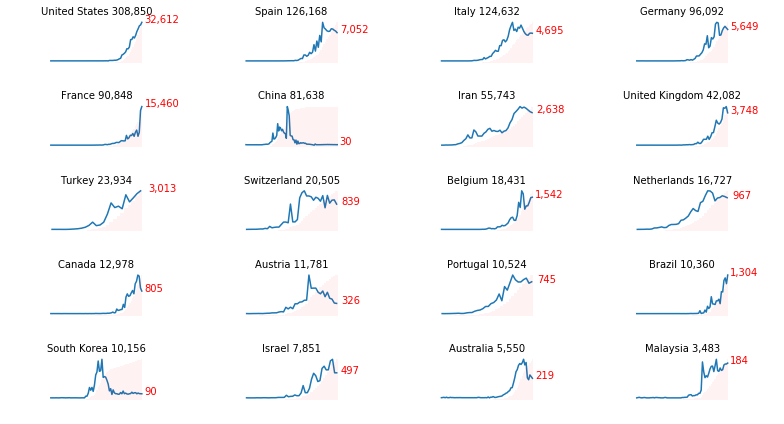

In [16]:
top = 20
# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:top-2].country) + ['Australia', 'Malaysia']
# countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=4, nrows=round(len(countries)/4), figsize=(11,6), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until + oneday*2, cdata.loc[until].new_confirmed, format(cdata.loc[until].new_confirmed, ","), color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# print(f'\nNew confirmed cases by Top 10 US State as of {date.day}/{date.month}/2020')
# usa = df3[df3.country=='United States'].iloc[:10,[1,2,3,5,6]]
# usa

In [18]:
# print(f'\nNew confirmed cases by Top 10 US County as of {date.day}/{date.month}/2020')
# county = df0.loc[(df0.country=='US') & (df0.date==date)].sort_values(by='confirmed', ascending=False).set_index('date', drop=True)
# county = county[['admin2', 'state', 'confirmed', 'deaths', 'recovered']]
# county[:10]

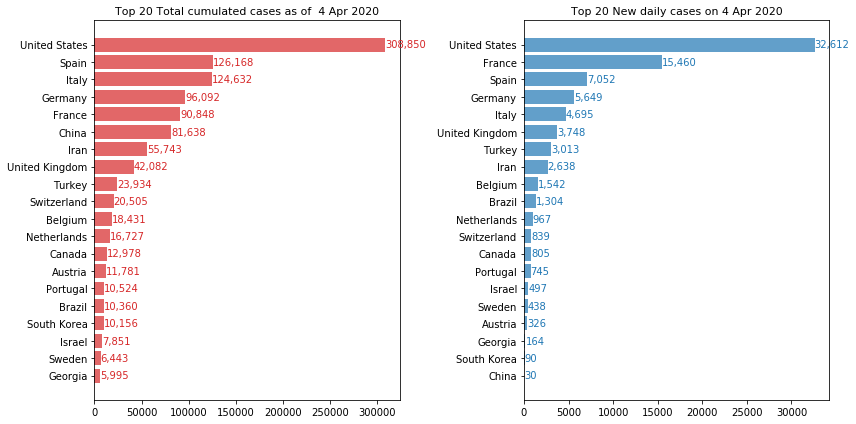

In [19]:
mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases as of  ','New daily cases on ']
colors = ['C3','C0']
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    data = latest[:top][['country',cols[i]]].reset_index(drop=True).set_index('country').sort_values(by=cols[i])
    ax.barh(data.index, data[cols[i]], color=colors[i], alpha=0.7)
    ax.set_title(f'Top {top} {titles[i]}{date.day} {mdict[date.month]} 2020', fontsize='11')
    for n, v in enumerate(data[cols[i]]):
        ax.text(v, n, format(v, ","), va='center', fontsize=10, color=colors[i])
plt.tight_layout()
plt.savefig('img/total_cases_bar', pad_inches=0)
plt.show()

In [20]:
threshold = 50 # set min threshold

df2 = df1[['country','confirmed','new_confirmed','growth','growth_avg','growth_avg_7']].reset_index()
df2 = df2.sort_values('date')

print(f'\nTop 20 countries with the highest day-on-day growth as of {date.day}/{date.month}/2020')
growthdata = df2.loc[(df2.date==date) & (df2.confirmed > 100)].sort_values(by='growth', ascending=False).set_index('country', drop=True)
growthdata[['confirmed','growth','growth_avg']][:20]


Top 20 countries with the highest day-on-day growth as of 4/4/2020


,confirmed,growth,growth_avg
country,,,
Guinea,111,1.521,1.553
Moldova,752,1.272,1.212
Belarus,440,1.254,1.247
Qatar,1325,1.233,1.154
France,90848,1.205,1.174
Niger,144,1.200,1.249
United Arab Emirates,1505,1.191,1.228
Morocco,919,1.162,1.116
Montenegro,201,1.155,1.178



Day-to-day % growth of new confirmed cases for 4 weeks prior to 4 Apr 2020


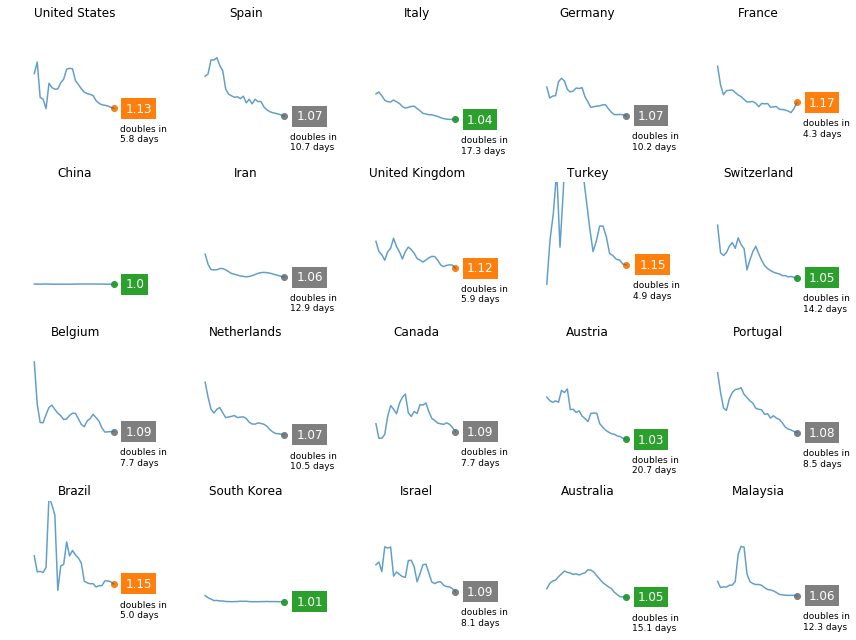

In [21]:
countries = list(latest[:18].country) + ['Australia', 'Malaysia']

print(f'\nDay-to-day % growth of new confirmed cases for 4 weeks prior to {date.day} {mdict[date.month]} 2020')
fig, axes = plt.subplots(ncols=5, nrows=round(len(countries)/5), figsize=(12,9), constrained_layout=True)
col = ['growth_avg']
for i, ax in zip(range(len(countries)), axes.flat):
    data = df2[df2.country==countries[i]].iloc[-28:].reset_index(drop=True)
    ax.plot(data[col].clip(1)[:], alpha=0.7)
    latest_growth = data[col].iloc[-1]
    if latest_growth[0] < 2**(1/14):
        color = 'C2'
    elif latest_growth[0] < 2**(1/7):
        color = 'C7'
    elif latest_growth[0] < 2**(1/4):
        color = 'C1'
    else: color = 'C3'
    double_days = f'doubles in\n{round(math.log(2)/math.log(latest_growth),1)} days' if latest_growth[0] > 2**(1/30) else ''
    ax.scatter(data.index.max(), latest_growth, marker='o', color=color)
    #ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
    ax.text(data.index.max()+4, latest_growth, str(round(latest_growth[0],2)),
            color='white', ha='left', va='center', size=12, bbox=dict(facecolor=color, edgecolor='none'))
    ax.text(data.index.max()+2, latest_growth-0.2, double_days, ha='left', va='center', size=9)
    ax.set_ylim(0.9, 1.8)
    ax.axis('off')
    ax.set_title(countries[i], fontsize=12)
plt.tight_layout()
plt.savefig('img/growth', pad_inches=0)
plt.savefig(f'img_archive/growth_{str(date)[:10]}', pad_inches=0)
plt.show()

In [22]:
print('Day-to-day % growth of new confirmed cases over the past 7 days')
dfgrowth = pd.pivot_table(df2, values=['growth'], index=['country'], columns=['date'], aggfunc='sum').loc[countries]
dfgrowth.iloc[:,-7:]

Day-to-day % growth of new confirmed cases over the past 7 days


growth                                              \
date           2020-03-29 2020-03-30 2020-03-31 2020-04-01 2020-04-02   
country                                                                 
United States       1.160      1.153      1.156      1.146      1.139   
Spain               1.100      1.092      1.091      1.083      1.074   
Italy               1.054      1.048      1.043      1.041      1.042   
Germany             1.080      1.075      1.081      1.082      1.079   
France              1.093      1.124      1.129      1.067      1.090   
China               1.001      1.001      1.000      1.000      1.000   
Iran                1.089      1.078      1.074      1.067      1.060   
United Kingdom      1.142      1.134      1.136      1.172      1.144   
Turkey              1.245      1.175      1.250      1.159      1.157   
Switzerland         1.081      1.048      1.072      1.052      1.055   
Belgium             1.186      1.089      1.095      1.087      1.093   
Netherlands         1.113      1.080      1.081      1.076      1.075   
Canada              1.126      1.168      1.157      1.161      1.135   
Austria             1.088      1.060      1.072      1.048      1.043   
Portugal            1.153      1.124      1.111      1.107      1.101   
Brazil              1.086      1.176      1.147      1.196      1.177   
South Korea         1.012      1.012      1.009      1.011      1.009   
Israel              1.174      1.131      1.116      1.137      1.126   
Australia           1.102      1.099      1.051      1.044      1.053   
Malaysia            1.068      1.059      1.057      1.063      1.061   

                                      
date           2020-04-03 2020-04-04  
country                               
United States       1.125      1.119  
Spain               1.067      1.059  
Italy               1.041      1.039  
Germany             1.070      1.062  
France              1.226      1.205  
China               1.000      1.000  
Iran                1.054      1.050  
United Kingdom      1.132      1.098  
Turkey              1.154      1.144  
Switzerland         1.052      1.043  
Belgium             1.099      1.091  
Netherlands         1.068      1.061  
Canada              1.081      1.066  
Austria             1.030      1.028  
Portugal            1.078      1.076  
Brazil              1.126      1.144  
South Korea         1.009      1.009  
Israel              1.072      1.068  
Australia           1.047      1.041  
Malaysia            1.057      1.056

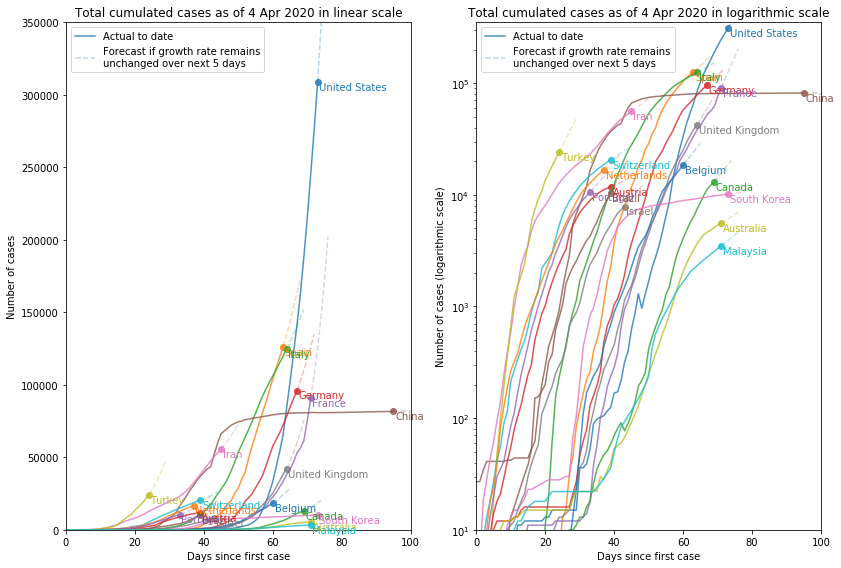

In [39]:
xmax = 45
future_days = 5
ylabels = ['Number of cases', 'Number of cases (logarithmic scale)']
latestdate = f'{date.day} {mdict[date.month]} 2020'
titles = [f'Total cumulated cases as of {latestdate} in linear scale',
          f'Total cumulated cases as of {latestdate} in logarithmic scale']
fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2) 
for s in range(2): # one for log scale, one for regular scale
    for i, country in enumerate(countries):
        color = f'C{i}' if i < 10 else f'C{str(i)[-1]}'   
        # Data for actual
        data = df2.loc[(df2.country==country), 'confirmed'].reset_index(drop=True)
        ax[s].plot(data, alpha=0.8, color=color, label='Actual to date')
        ax[s].scatter(data.index.max(), data.iloc[-1], alpha=0.8, color=color)
        if s==0:
            if i<20 : ax[s].text(data.index.max()+0.5, data.max(), country,
                                 va='top', ha='left', fontsize=10, color=color)
        else:
            ax[s].text(data.index.max()+0.5, data.max(), country, va='top', ha='left', fontsize=10, color=color)
        # Data for forecast
        latest_growth = df2.loc[(df2.country==country), 'growth'].rolling(window=3).mean().iloc[-1]
        latest_total = df2.loc[(df2.country==country), 'confirmed'].iloc[-1]
        extrapolate = [data.iloc[-1]]
        new_data = latest_total
        for day in range(future_days):
            new_data = new_data * latest_growth
            extrapolate.append(new_data)
        xdays = range(data.index.max(), data.index.max()+future_days+1)
        ax[s].plot(xdays, extrapolate, alpha=0.3, ls='dashed', color=color, label=f'Forecast if growth rate remains\nunchanged over next {future_days} days')
        if i==0: ax[s].legend()
    if s==1: plt.yscale('log')
    ax[s].set_title(titles[s])
    ax[s].set_xlim(0, df2[df2.country=='China'].reset_index().index.max()+5)
    ax[s].set_ylim(10, 3.5e5)
    ax[s].set_ylabel(ylabels[s])
    ax[s].set_xlabel('Days since first case')
plt.tight_layout()
plt.savefig(f'img/total_cases', pad_inches=0)
plt.savefig(f'img_archive/total_cases_{str(date)[:10]}', pad_inches=0)
plt.show()

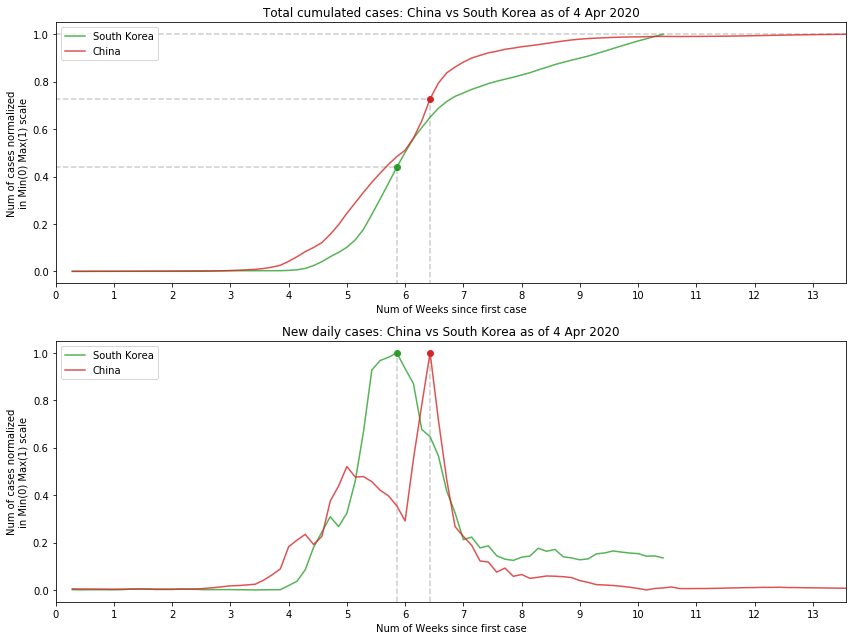

In [24]:
color = ['C2','C3']
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases: China vs South Korea as of', 'New daily cases: China vs South Korea as of']
fig, axes = plt.subplots(figsize=(12,9), nrows=2, ncols=1)
for i, ax in zip(range(len(cols)), axes.flat):
    for c, country in enumerate(['South Korea','China']):
        data0 = df2.loc[df2.confirmed > 0]
        data1 = df2.loc[df2.country==country][cols[i]].rolling(window=3).mean().reset_index(drop=True)
        if i==1:
            peakday = data1[data1==data1.max()].index[0]
        else:
            data2 = df2.loc[df2.country==country][cols[i+1]].rolling(window=3).mean().reset_index(drop=True)
            peakday = data2[data2==data2.max()].index[0]
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.array(data1).reshape(-1, 1))
        ax.plot(data, label=country, color=color[c], alpha=0.8)
        xmax = df2.loc[df2.country=='China'].reset_index().index.max()
        if i==1:
            ax.vlines(peakday, -0.05, 1, linestyle='dashed', alpha=0.2)
            ax.scatter(peakday, 1, marker='o', color=color[c])
        else:
            ax.vlines(peakday, -1, data[peakday], linestyle='dashed', alpha=0.2)
            ax.hlines(data[peakday], -1, peakday, linestyle='dashed', alpha=0.2)
            ax.hlines(1, -1, xmax, linestyle='dashed', alpha=0.1)
            ax.scatter(peakday, data[peakday], marker='o', color=color[c])
        ax.set_title(f'{titles[i]} {latestdate}')
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(0, xmax)
        ax.set_xticks(np.array(range(0,xmax,7)))
        ax.set_xticklabels((np.array(range(0,xmax,7))/7).astype(int))
        ax.set_ylabel('Num of cases normalized\nin Min(0) Max(1) scale')
        ax.set_xlabel('Num of Weeks since first case')
        ax.legend(loc='upper left')
        plt.tight_layout()
plt.savefig('img/china_korea', pad_inches=0)
plt.show()

### 3. Forecasting

In [25]:
# country='Italy'
# rolling=1
# days=270
# fit_start=None
# fit_end='20200319'
# showzero=True
# showpeak=True
# showforecast=True
# A=None
# K=None
# C=None
# Q=None
# B=None
# v=None

# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to Richard's curve model
def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=110,
                 showzero=True, showpeak=True, showforecast=True,
                 A=None, K=None, C=None, Q=None, B=None, v=None, df2=df2):

    data = df2.loc[df2.country==country].reset_index(drop=True)
    dates = data.date
    latestdate = dates.iloc[-1]

    # # All dates in raw Actuals
    # dates = df2.loc[df2.country==country].reset_index(drop=True).date
    # # All raw Actuals
    # actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
    # actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

    # Limit Actual data period for model fit
    oneday = pd.Timedelta(1, unit='days')
    fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
    fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
    index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
    index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
    actual1 = data.confirmed.iloc[index_start:index_end]

    # Data for model fit input after rolling average
    dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
    actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
    xdata = np.array(range(rolling,len(actual2)+rolling)) # TO BE CHECKED
    ydata = np.array(actual2.values)

    # Auto fit model
    popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
    # Hyperparams of auto fit
    A0, K0, C0, Q0, B0, v0 = popt

    # Overwrite auto fit hyperparams if manual value exists
    A = A0 if A==None else A
    K = K0 if K==None else K
    C = C0 if C==None else C
    Q = Q0 if Q==None else Q
    B = B0 if B==None else B
    v = v0 if v==None else v

    # Calculate prediction over required num of days
    xdata2 = np.array(range(days))
    predcalc = richards(xdata2, A, K, C, Q, B, v)
    pred_index = range(actual2.index.min(), days+actual2.index.min())

    # Forecast dates that overlap with Actuals
    predict_dates1 = list(filter(lambda row: row <= dates.index.max(), pred_index))
    dates_part_1 = []
    for dy in predict_dates1:
        dates_part_1.append(dates.loc[dy]) 
    predict1 = pd.DataFrame(predcalc[:len(dates_part_1)], columns=['predict'], index=pred_index[:len(dates_part_1)]).clip(0)
    data = data.join(predict1)

    # Forecast dates beyond Actuals period
    predict_dates2 = list(filter(lambda row: row > dates.index.max(), pred_index))
    dates_part_2 = []
    for ix in range(len(predict_dates2)):
        dates_part_2.append(dates.max() + oneday * (ix+1))
    predict2 = pd.DataFrame(predcalc[len(dates_part_1):], columns=['predict'], index=pred_index[len(dates_part_1):])
    predict2['date'] = dates_part_2
    predict2['country'] = country

    # Combine both tables and calc new cases & growth
    data = pd.concat([data, predict2])
    data.predict = data.predict.fillna(-1)
    data.predict = data.predict.astype(int)
    data.predict = data.predict.replace(-1, np.nan)
    data['new_predict'] = data.predict.diff()
    data['p_growth'] = np.nan
    for i in data.index:
        data.iloc[i, data.columns.get_loc('p_growth')] = 0 if data.iloc[i-1].predict == 0 else round(data.iloc[i].predict/data.iloc[i-1].predict,3).clip(1)    
    rolling_window = 3
    data['p_gr_avg'] = round(data.p_growth.rolling(window=rolling_window).mean(),3).clip(1)
    data['p_gr_avg_7'] = round(data.p_growth.rolling(window=7).mean(),3).clip(1)
    data = data[['date', 'country', 'confirmed', 'new_confirmed', 'growth', 'growth_avg', 'growth_avg_7',
                 'predict', 'new_predict', 'p_growth', 'p_gr_avg', 'p_gr_avg_7']]

    # Save df in csv
    data.to_csv(f"dfdata/forecast_{country.replace(' ','_')}.csv")
    data.to_csv(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}.csv")

    # Find dates for plot labels
    # Latest available date in raw Actual
    latestindex = data[data.confirmed.isnull()].index.min()-1
    latestdate  = data.date.iloc[latestindex]

    # Date of plateau
    oneday = pd.Timedelta(1, unit='days')
    zeroindex = data.iloc[latestindex:][data.iloc[latestindex:].new_predict < 0.5].index.min()
    to_zero_days  = zeroindex - latestindex
    to_zero_weeks = round(to_zero_days/7)
    zerodate = latestdate + oneday*to_zero_days
    if (to_zero_days < 5) | (np.isnan(zeroindex)): showpeak = False

    # Date of peak
    peakindex = data[data.new_predict==data.new_predict.max()].index[0]
    to_peak_days  = peakindex - latestindex
    to_peak_weeks = round(to_peak_days/7)
    peakdate = latestdate + oneday*to_peak_days
    if to_peak_days < 5: showpeak = False

    # Plot prediction
    fig, ax = plt.subplots(figsize=(12,5), ncols=2, nrows=1)
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    if showforecast==True:
        ax[0].plot(data.date, data.predict,  ls='dashed', c='C1', label='Forecast')
        ax[1].plot(data.date, data.new_predict, ls='dashed', c='C1', label='Forecast')

    # Plot actual
    value_latest = data.confirmed.iloc[latestindex]
    value_latest_new = data.new_confirmed.iloc[latestindex]
    ax[0].plot(data.date, data.confirmed, c='C0', label='Actual to date')
    ax[0].scatter(latestdate, int(value_latest), c='C0')
    ax[0].text(latestdate+oneday*2, value_latest, f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(value_latest), ",")} cases', va='top')
    ax[1].plot(data.date, data.new_confirmed, c='C0', label='Actual daily')
    ax[1].scatter(latestdate, int(value_latest_new), color='C0')
    ax[1].text(latestdate+oneday*2, value_latest_new, f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(value_latest_new), ",")} cases', va='top')

    # Plot prediction end points
    if showforecast==True:
        if showzero==True:
            ax[0].scatter(zerodate, data.predict.max(), c='C1')      
            predictmax = int(math.ceil(data.predict.max()/100.0))*100 if data.predict.max() > value_latest else int(math.ceil(value_latest/100.0))*100
            zerolabel = f"{int(round(to_zero_weeks))} week{'s' if to_zero_weeks>1 else ''}"
            ax[0].text(zerodate+oneday*2, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {zerolabel}", va='top')
        if showpeak==True:
            ax[1].scatter(peakdate, data.new_predict.max(), c='C1')
            peaklabel = f"{int(round(to_peak_weeks))} week{'s' if to_peak_weeks>1 else ''}"
            ax[1].text(peakdate+oneday*2, data.new_predict.max(), f"{peakdate.day} {mdict[peakdate.month]}\nin {peaklabel}", va='top')
        loc_legend = 'center right'

    if showforecast==False:
        ax[0].text(data.date.iloc[0] + oneday*days/2, (data.confirmed.min()+data.confirmed.max())/2, 'Latest forecast\nto be reviewed', bbox=dict(facecolor='none', edgecolor='C1', linewidth=2, linestyle='dashed'), ha='center')
        ax[1].text(data.date.iloc[0] + oneday*days/2, (data.new_confirmed.min()+data.new_confirmed.max())/2, 'Latest forecast\nto be reviewed', bbox=dict(facecolor='none', edgecolor='C1', linewidth=2, linestyle='dashed'), ha='center')
        loc_legend = 'lower right'

    # Plot titles and axis
    ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
    ax[0].set_ylabel('Num of cumulative cases')    
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[0].legend(loc=loc_legend)

    ax[1].set_title(f'{country.upper()}\nNew daily cases')
    ax[1].set_ylabel('Num of new daily cases')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[1].legend(loc=loc_legend)

    if showforecast==False:
        ax[0].set_xlim(dates.values[0], dates.values[0] + oneday * days)
        ax[1].set_xlim(dates.values[0], dates.values[0] + oneday * days)

    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0)
    plt.savefig(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}", pad_inches=0)    
    plt.show()

    print(country)
    print(f'Auto fit  : A={int(A0)}, K={int(K0)}, C={round(C0,4)}, Q={round(Q0,4)}, B={round(B0,4)}, v={round(v0,4)}')
    if (A!=A0) | (K!=K0) | (C!=C0) | (Q!=Q0) | (B!=B0) | (v!=v0):
        print(f'Manual fit: A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')

**Instructions on how to run the model**

In [26]:
# Use predict_plot function to run model by country:
#
# predict_plot('United Kingdom',                         # compulsory
#              rolling=1,                                # optional: number of period of moving avg if > 1
#              fit_start='20200311', fit_end='20200311', # optional: but essential if converge error
#              days=110,                                 # optional: number of days to plot (default 110)
#              A=.., K=.., C=.., Q=.., B=.., v=..        # optional: manual tweak of Richard's curve parameters
#              showzero=True, showpeak=True)             # optional: show or hide date of plateau or peak
#
# 1. Run the function with predict_plot(country)
#
# 2. If error message "Optimal parameters not found" is generated, this means that
#    data points can't be fit into a curve due to failure to converge after 3000 iterations
#
# 3. In case of such error, change fit_start or/and fit_end (dates) and/or rolling period (days)
#    manually until the error disappears and a resonable result is generated.
#
# 4. If the curve overfits and/or it doesn't follow the expected result, tweak A/K/C/Q/B/v
#    parameters manually. Use the auto-generated parameter values shown underneath the plots
#    as a starting point and refer to be guide below on the effect of changing these parameters.

![title](img/richards_curve_params.png)

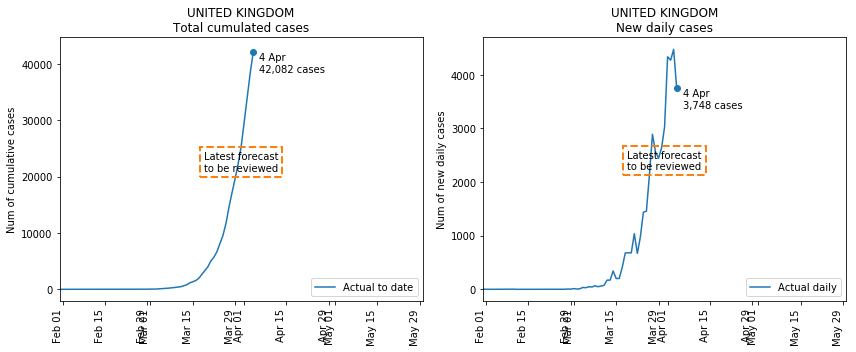

United Kingdom
Auto fit  : A=38835, K=-20027, C=1.0013, Q=0.0001, B=-0.2282, v=0.003
Manual fit: A=60000, K=-20027, C=1.0013, Q=0.0001, B=-0.2282, v=0.003


In [115]:
# predict_plot('United Kingdom', days=50, fit_start='20200311', fit_end='20200321')
# predict_plot('United Kingdom', days=50, fit_start='20200317', fit_end='20200329', Q=0.00013)
predict_plot('United Kingdom', days=120, fit_start='20200317', fit_end='20200329', A=60000, Q=0.00005, showforecast=False)

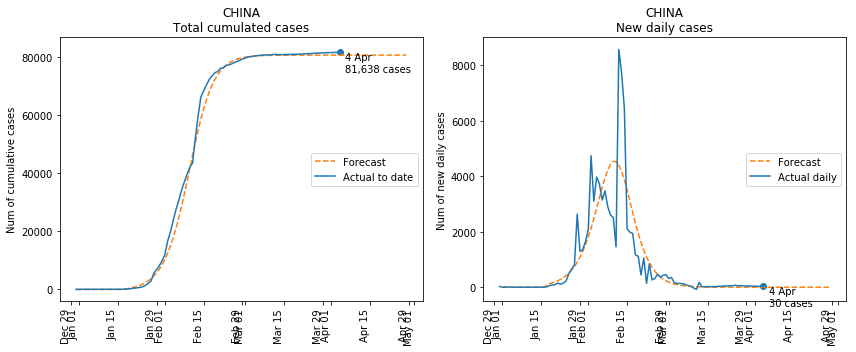

China
Auto fit  : A=-513, K=757, C=0.0074, Q=140.3767, B=0.2366, v=1.1804


In [28]:
predict_plot('China', days=120, showzero=False, fit_end='20200323')

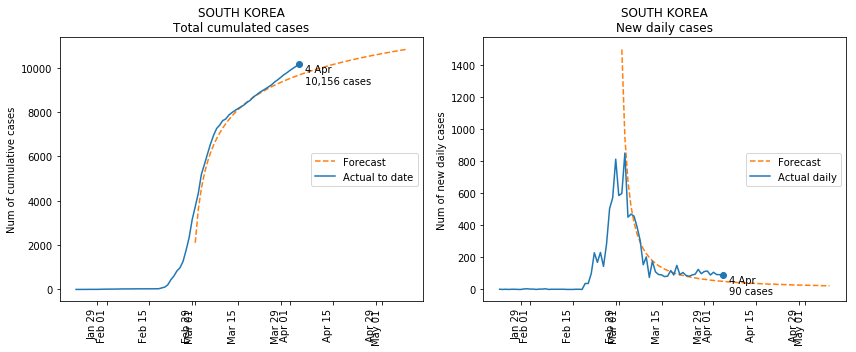

South Korea
Auto fit  : A=12509, K=5698, C=-4.7355, Q=5.0574, B=-0.0323, v=2.6748


In [29]:
#predict_plot('South Korea', rolling=0, days=50, showzero=False, fit_end='20200323')
#predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200326')
predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200329')

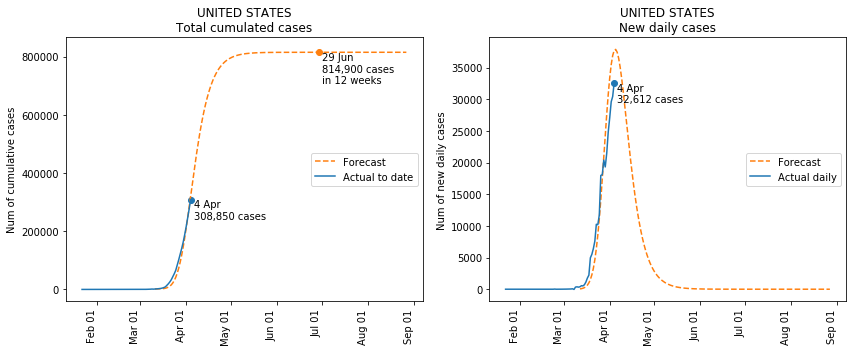

United States
Auto fit  : A=1422, K=2316, C=0.3143, Q=1.3323, B=0.1816, v=0.2133
Manual fit: A=1422, K=5000, C=0.3143, Q=2, B=0.14, v=0.2133


In [85]:
#predict_plot('United States', days=100, fit_start='20200316', fit_end='20200321', B=-1.5)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=100, B=0.3, Q=4)
#predict_plot('United States', days=200, fit_start='20200311', fit_end='20200325', B=0.15, K=4000)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=120, B=0.2, K=3000, Q=2)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=140, B=0.17, K=3500, Q=2)
predict_plot('United States', fit_start='20200311', fit_end='20200325', days=170, B=0.14, K=5000, Q=2)

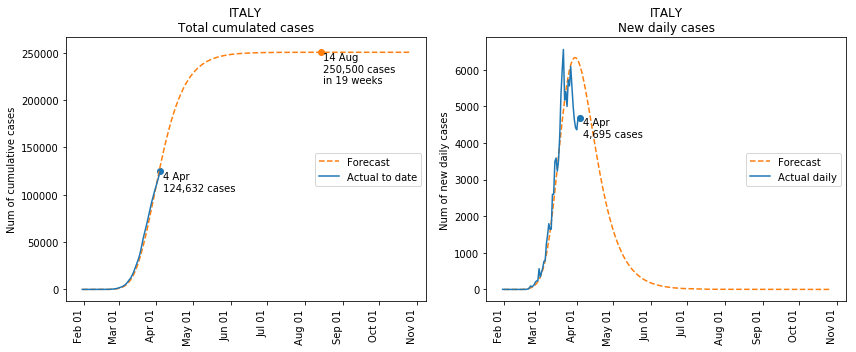

Italy
Auto fit  : A=-14, K=2370, C=0.458, Q=6.2647, B=0.0745, v=0.1678


In [31]:
predict_plot('Italy', days=270, showpeak=False, fit_end='20200319')

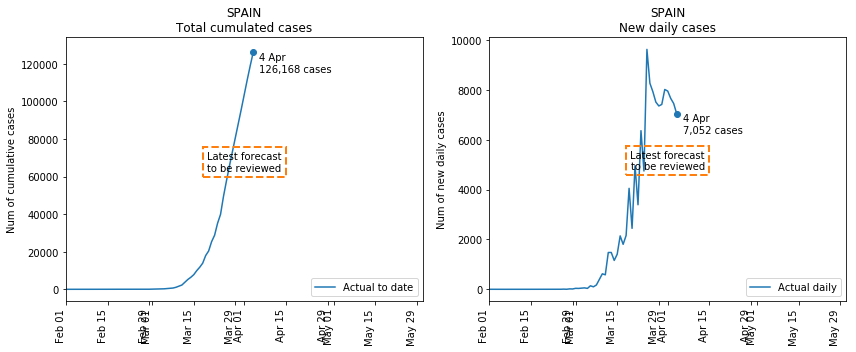

Spain
Auto fit  : A=95661, K=-98863, C=1.0008, Q=0.0001, B=-0.2451, v=0.0011
Manual fit: A=130000, K=-98863, C=1.0008, Q=0.0, B=-0.2451, v=0.0011


In [102]:
#predict_plot('Spain', days=70, fit_start='20200313', fit_end='20200323')
#predict_plot('Spain', days=70, fit_start='20200314', fit_end='20200329')
#predict_plot('Spain', days=70, fit_start='20200316', fit_end='20200329', A=120000, Q=0.00005)
predict_plot('Spain', days=120, fit_start='20200316', fit_end='20200329', A=130000, Q=0.00004, showforecast=False)

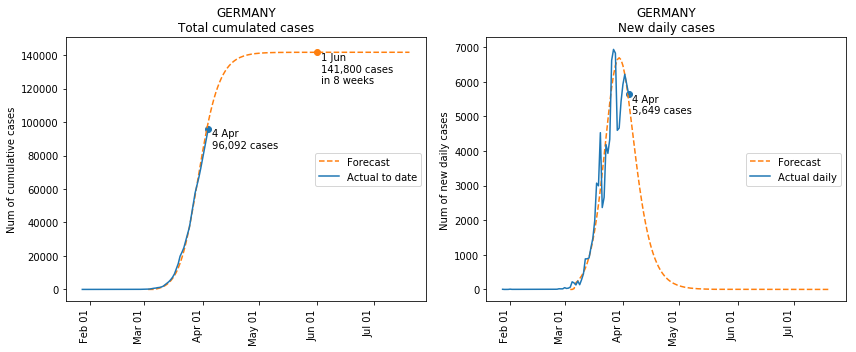

Germany
Auto fit  : A=70, K=632, C=0.0398, Q=2.4717, B=0.2099, v=0.6904
Manual fit: A=-700, K=632, C=0.0398, Q=2.4717, B=0.17, v=0.6904


In [100]:
predict_plot('Germany', rolling=1, days=140, fit_start='20200303', fit_end='20200317', A=-700, B=0.17)

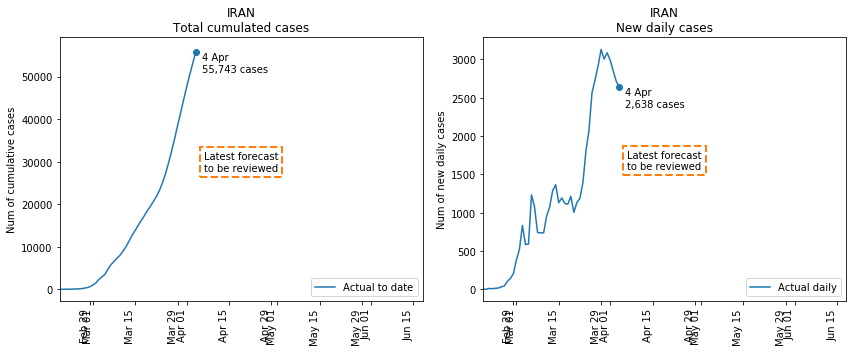

Iran
Auto fit  : A=-4718, K=5420, C=0.3601, Q=0.6561, B=0.0014, v=0.0139


In [34]:
predict_plot('Iran', days=120, fit_end='20200401', showforecast=False)
#predict_plot('Iran', days=200, fit_start='20200307', fit_end='20200321', B=-0.7, v=12)
#predict_plot('Iran', days=200, fit_start='20200309', fit_end='20200321')

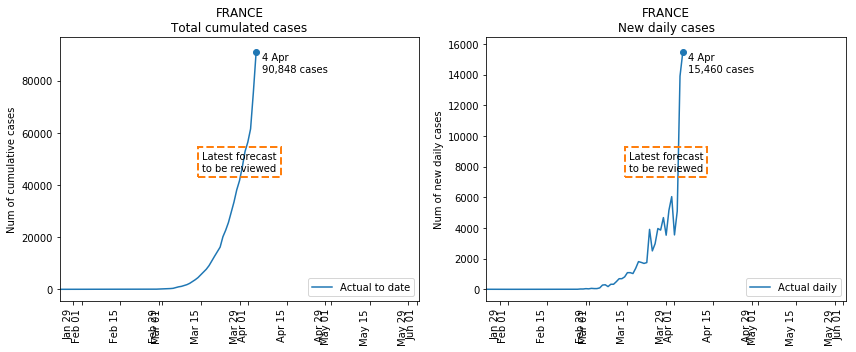

France
Auto fit  : A=67751, K=-70343, C=1.0021, Q=0.0002, B=-0.1731, v=0.0029
Manual fit: A=105000, K=-70343, C=1.0021, Q=0.0001, B=-0.1731, v=0.0029


In [62]:
#predict_plot('France', days=80, fit_start='20200309', fit_end='20200320')
#predict_plot('France', days=80, fit_start='20200314', fit_end='20200329')
predict_plot('France', days=130, fit_start='20200314', fit_end='20200329', A=105000, Q=0.00007, showforecast=False)

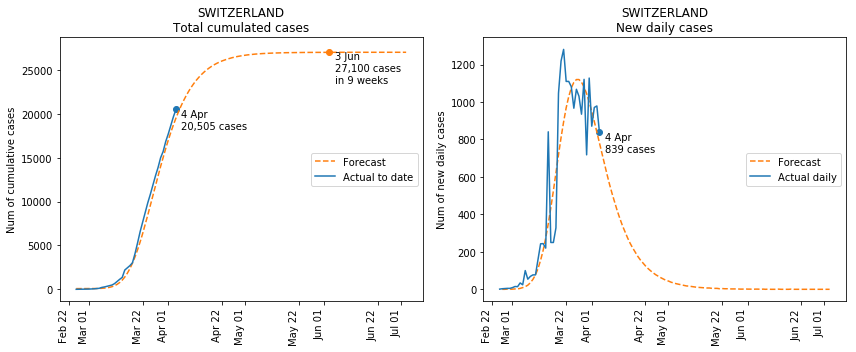

Switzerland
Auto fit  : A=80, K=770, C=0.5874, Q=3.2377, B=0.1213, v=0.1452


In [99]:
#predict_plot('Switzerland', days=75, fit_end='20200328', K=240, A=-900)
predict_plot('Switzerland', days=130)

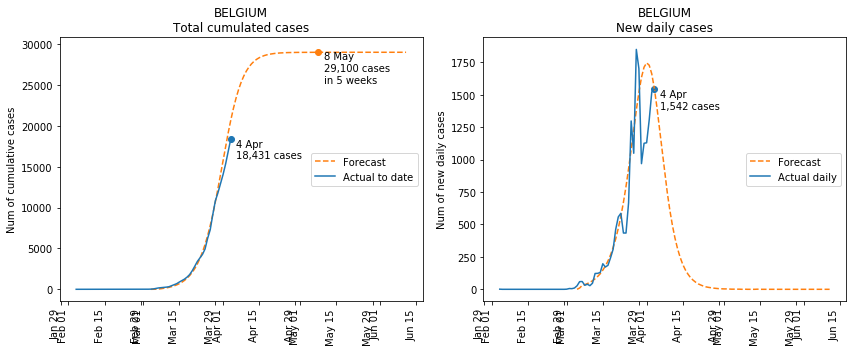

Belgium
Auto fit  : A=3, K=547, C=0.0078, Q=13.6792, B=0.2611, v=1.2866
Manual fit: A=-120, K=547, C=0.0078, Q=13.6792, B=0.2611, v=1.2866


In [98]:
predict_plot('Belgium', days=100, fit_start='20200304', A=-120)

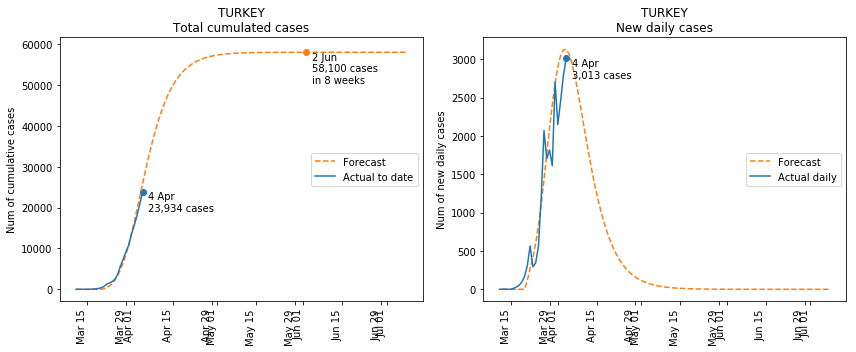

Turkey
Auto fit  : A=13, K=1211, C=0.5119, Q=3.7034, B=0.1593, v=0.1833
Manual fit: A=-300, K=1211, C=0.5119, Q=3.7034, B=0.1593, v=0.1833


In [91]:
predict_plot('Turkey', days=120, fit_end='20200403', A=-300)

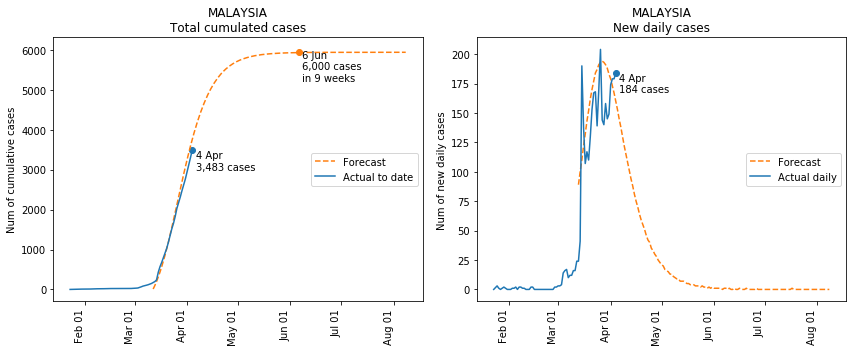

Malaysia
Auto fit  : A=-367, K=324, C=0.5174, Q=0.6486, B=0.0945, v=0.3206
Manual fit: A=-500, K=324, C=0.5174, Q=0.6486, B=0.0945, v=0.3206


In [93]:
#predict_plot('Malaysia', days=60, fit_start='20200307', fit_end='20200320', K=300, B=0.3, Q=5)
#predict_plot('Malaysia', days=90, fit_start='20200307', fit_end='20200320', K=400, B=0.2, Q=4)
#predict_plot('Malaysia', days=100, fit_start='20200313', fit_end='20200325')
predict_plot('Malaysia', days=150, fit_start='20200312', fit_end='20200401', A=-500)

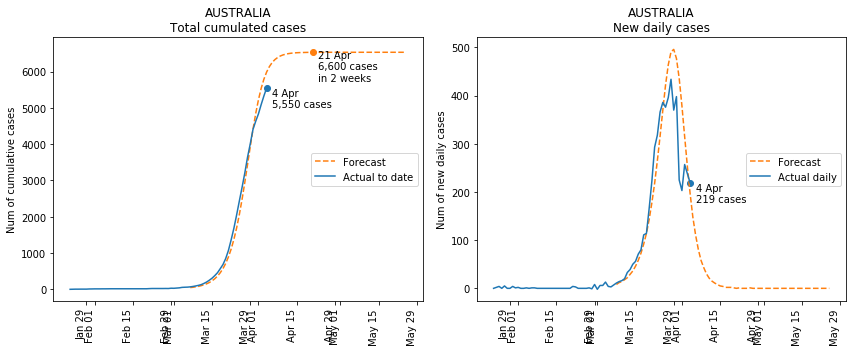

Australia
Auto fit  : A=42, K=140, C=0.0029, Q=7.142, B=0.3725, v=1.4798
Manual fit: A=15, K=140, C=0.0029, Q=7.142, B=0.35, v=1.4798


In [97]:
#predict_plot('Australia', days=60, fit_end='20200317', B=0.25, showpeak=False)
#predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200317', showpeak=False, B=0.28, K=300, Q=12)
predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200328', A=15, B=0.35)

### 4. Impact of lockdown on growth

In [47]:
# countries = ['China','South Korea','Malaysia','Singapore','Taiwan','Italy']
# fig, ax = plt.subplots(figsize=(12,8))
# for country in countries:
#     data0 = df1a.loc[df1a.country==country].sort_index().new_confirmed
#     dates = data0.index
#     data1 = data0.rolling(window=7).mean()
#     scaler = MinMaxScaler()
#     data = scaler.fit_transform(np.array(data1).reshape(-1, 1))
#     ax.plot(data, label=country, alpha=0.8)
#     ax.legend()
#     plt.tight_layout()

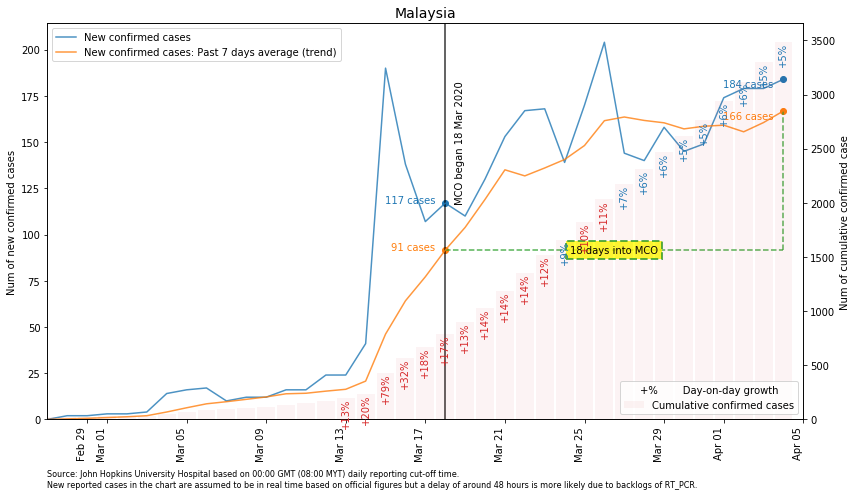

In [48]:
# Assign values
country   = 'Malaysia'
xmin      = pd.to_datetime('20200227', format='%Y%m%d')
txtmin    = pd.to_datetime('20200312', format='%Y%m%d')
lockstart = pd.to_datetime('20200318', format='%Y%m%d')
locklabel = 'MCO'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/2, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.scatter(lockstart, data0lock, marker='o', color='C0')
ax.scatter(lockstart, data1lock, marker='o', color='C1')
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.scatter(lockend, data1now, marker='o', color='C1')
ax.hlines(data1lock, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data1lock, f'{lockperiod.days+1} days into {locklabel}', va='center', ha='center',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
ax.text(lockstart-oneday/2, data1lock, f'{int(data1lock)} cases', ha='right', color='C1')
ax.text(lockstart-oneday/2, data0lock, f'{int(data0lock)} cases', ha='right', color='C0')
ax.text(lockend-oneday/2, data1now, f'{int(data1now)} cases', va='top', ha='right', color='C1')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT (08:00 MYT) daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='lower right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

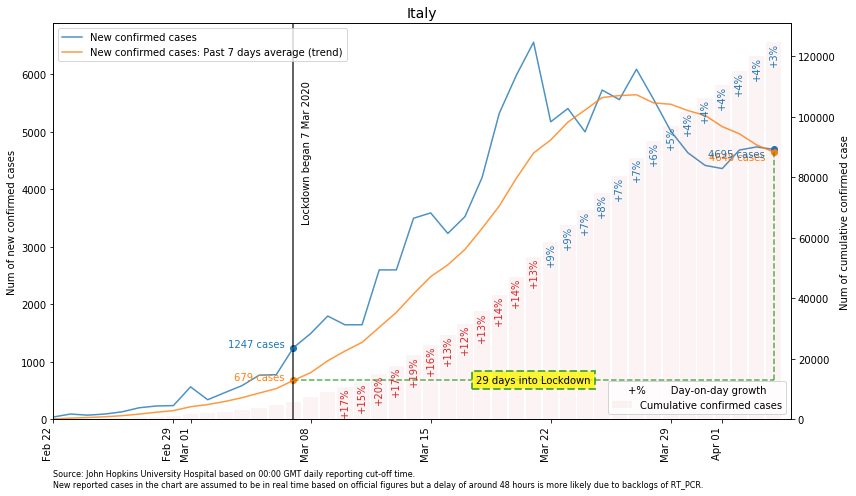

In [49]:
# Assign values
country   = 'Italy'
xmin      = pd.to_datetime('20200222', format='%Y%m%d')
txtmin    = pd.to_datetime('20200309', format='%Y%m%d')
lockstart = pd.to_datetime('20200307', format='%Y%m%d')
locklabel = 'Lockdown'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/2, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.scatter(lockstart, data0lock, marker='o', color='C0')
ax.scatter(lockstart, data1lock, marker='o', color='C1')
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.scatter(lockend, data1now, marker='o', color='C1')
ax.hlines(data1lock, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data1lock, f'{lockperiod.days+1} days into {locklabel}', va='center', ha='center',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
ax.text(lockstart-oneday/2, data1lock, f'{int(data1lock)} cases', ha='right', color='C1')
ax.text(lockstart-oneday/2, data0lock, f'{int(data0lock)} cases', ha='right', color='C0')
ax.text(lockend-oneday/2, data1now, f'{int(data1now)} cases', va='top', ha='right', color='C1')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='lower right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

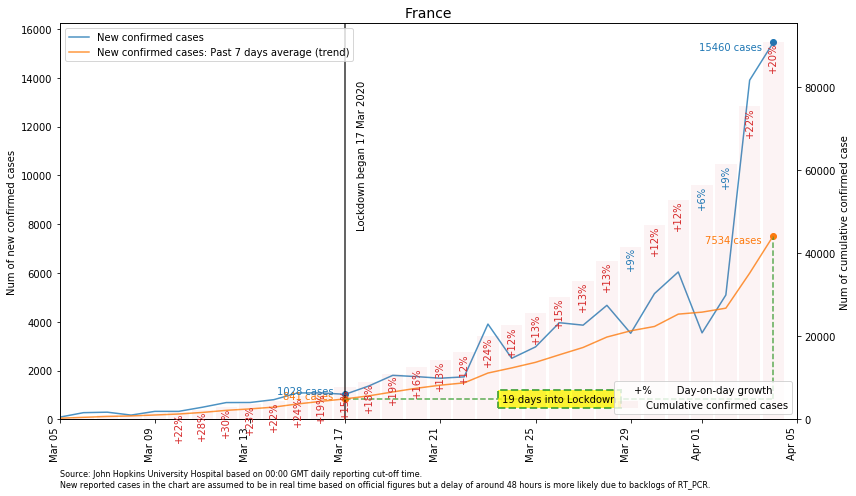

In [50]:
# Assign values
country   = 'France'
xmin      = pd.to_datetime('20200305', format='%Y%m%d')
txtmin    = pd.to_datetime('20200309', format='%Y%m%d')
lockstart = pd.to_datetime('20200317', format='%Y%m%d')
locklabel = 'Lockdown'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/2, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.scatter(lockstart, data0lock, marker='o', color='C0')
ax.scatter(lockstart, data1lock, marker='o', color='C1')
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.scatter(lockend, data1now, marker='o', color='C1')
ax.hlines(data1lock, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data1lock, f'{lockperiod.days+1} days into {locklabel}', va='center', ha='center',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
ax.text(lockstart-oneday/2, data1lock, f'{int(data1lock)} cases', ha='right', color='C1')
ax.text(lockstart-oneday/2, data0lock, f'{int(data0lock)} cases', ha='right', color='C0')
ax.text(lockend-oneday/2, data1now, f'{int(data1now)} cases', va='top', ha='right', color='C1')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='lower right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

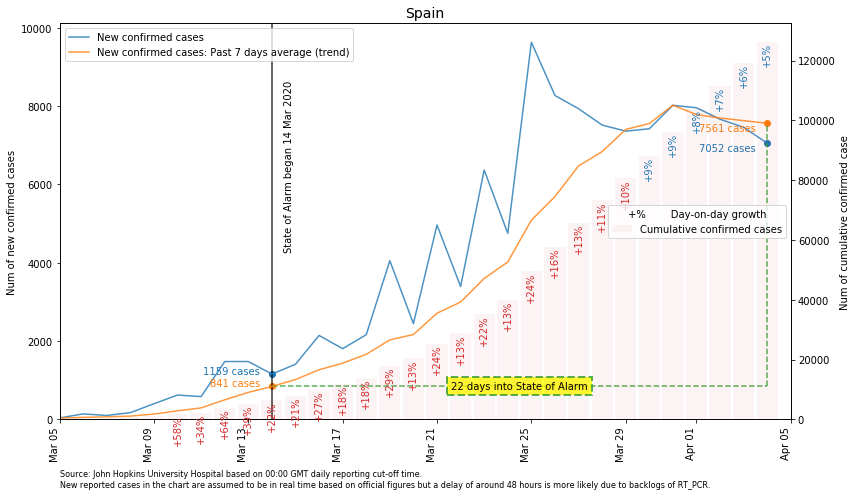

In [51]:
# Assign values
country   = 'Spain'
xmin      = pd.to_datetime('20200305', format='%Y%m%d')
txtmin    = pd.to_datetime('20200309', format='%Y%m%d')
lockstart = pd.to_datetime('20200314', format='%Y%m%d')
locklabel = 'State of Alarm'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/2, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.scatter(lockstart, data0lock, marker='o', color='C0')
ax.scatter(lockstart, data1lock, marker='o', color='C1')
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.scatter(lockend, data1now, marker='o', color='C1')
ax.hlines(data1lock, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data1lock, f'{lockperiod.days+1} days into {locklabel}', va='center', ha='center',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
ax.text(lockstart-oneday/2, data1lock, f'{int(data1lock)} cases', ha='right', color='C1')
ax.text(lockstart-oneday/2, data0lock, f'{int(data0lock)} cases', ha='right', color='C0')
ax.text(lockend-oneday/2, data1now, f'{int(data1now)} cases', va='top', ha='right', color='C1')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='center right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

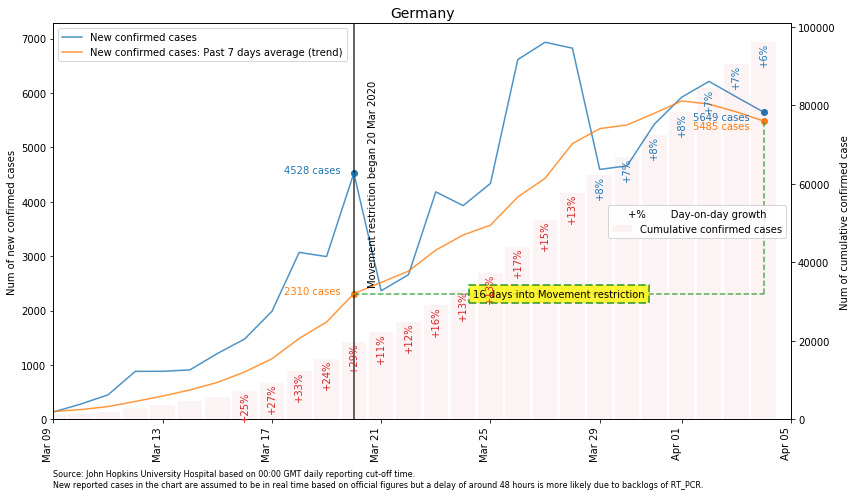

In [52]:
# Assign values
country   = 'Germany'
xmin      = pd.to_datetime('20200309', format='%Y%m%d')
txtmin    = pd.to_datetime('20200315', format='%Y%m%d')
lockstart = pd.to_datetime('20200320', format='%Y%m%d')
locklabel = 'Movement restriction'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/2, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.scatter(lockstart, data0lock, marker='o', color='C0')
ax.scatter(lockstart, data1lock, marker='o', color='C1')
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.scatter(lockend, data1now, marker='o', color='C1')
ax.hlines(data1lock, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data1lock, f'{lockperiod.days+1} days into {locklabel}', va='center', ha='center',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
ax.text(lockstart-oneday/2, data1lock, f'{int(data1lock)} cases', ha='right', color='C1')
ax.text(lockstart-oneday/2, data0lock, f'{int(data0lock)} cases', ha='right', color='C0')
ax.text(lockend-oneday/2, data1now, f'{int(data1now)} cases', va='top', ha='right', color='C1')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='center right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

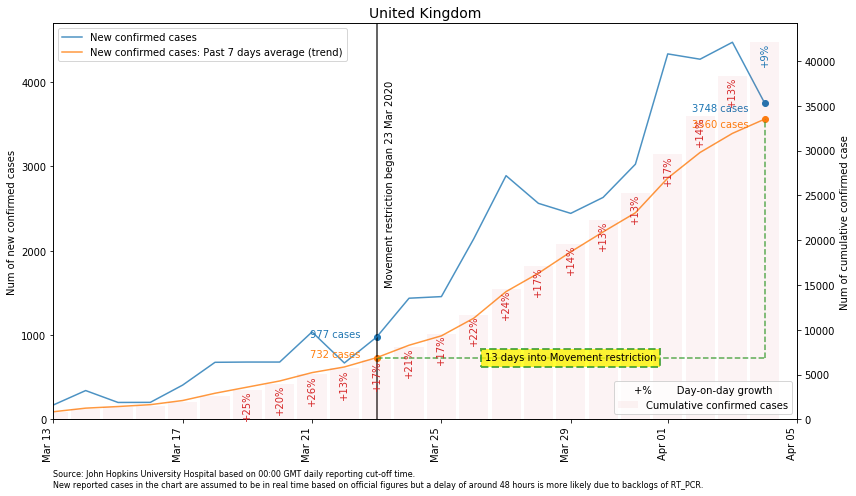

In [53]:
# Assign values
country   = 'United Kingdom'
xmin      = pd.to_datetime('20200313', format='%Y%m%d')
txtmin    = pd.to_datetime('20200318', format='%Y%m%d')
lockstart = pd.to_datetime('20200323', format='%Y%m%d')
locklabel = 'Movement restriction'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/4, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.scatter(lockstart, data0lock, marker='o', color='C0')
ax.scatter(lockstart, data1lock, marker='o', color='C1')
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.scatter(lockend, data1now, marker='o', color='C1')
ax.hlines(data1lock, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data1lock, f'{lockperiod.days+1} days into {locklabel}', va='center', ha='center',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
ax.text(lockstart-oneday/2, data1lock, f'{int(data1lock)} cases', ha='right', color='C1')
ax.text(lockstart-oneday/2, data0lock, f'{int(data0lock)} cases', ha='right', color='C0')
ax.text(lockend-oneday/2, data1now, f'{int(data1now)} cases', va='top', ha='right', color='C1')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='lower right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

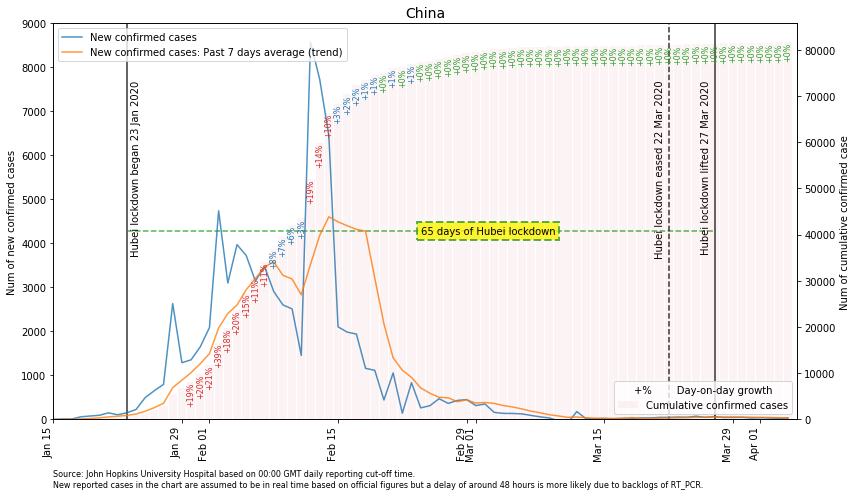

In [54]:
# Assign values
country   = 'China'
xmin      = pd.to_datetime('20200115', format='%Y%m%d')
txtmin    = pd.to_datetime('20200129', format='%Y%m%d')
lockstart = pd.to_datetime('20200123', format='%Y%m%d')
locklabel = 'Hubei lockdown'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend2   = pd.to_datetime('20200322', format='%Y%m%d')
lockend    = pd.to_datetime('20200327', format='%Y%m%d')

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

# Lockdown
ax.vlines(lockstart, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockstart+oneday/2, data0.new_confirmed.max()*0.9,
        f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
lockperiod = (lockend - lockstart)
ax.hlines(data0.new_confirmed.max()/2, lockstart, lockend, linestyle='dashed', alpha=0.8, color='C2')
ax.vlines(lockend, data1lock, data1now, linestyle='dashed', alpha=0.8, color='C2')
ax.text(lockstart+lockperiod/2, data0.new_confirmed.max()/2, f'{lockperiod.days+1} days of {locklabel}', va='center', ha='left',
        bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))

# Lockend
ax.vlines(lockend2, -50, data0.new_confirmed.max()*1.05, alpha=0.8, linestyle='dashed')
ax.text(lockend2-oneday*1.5, data0.new_confirmed.max()*0.9,
        f'{locklabel} eased {lockend2.day} {mdict[lockend2.month]} {lockend2.year}', rotation=90, va='top')
ax.vlines(lockend, -50, data0.new_confirmed.max()*1.05, alpha=0.8)
ax.text(lockend-oneday*1.5, data0.new_confirmed.max()*0.9,
        f'{locklabel} lifted {lockend.day} {mdict[lockend.month]} {lockend.year}', rotation=90, va='top')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color, fontsize=8)
# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='lower right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()

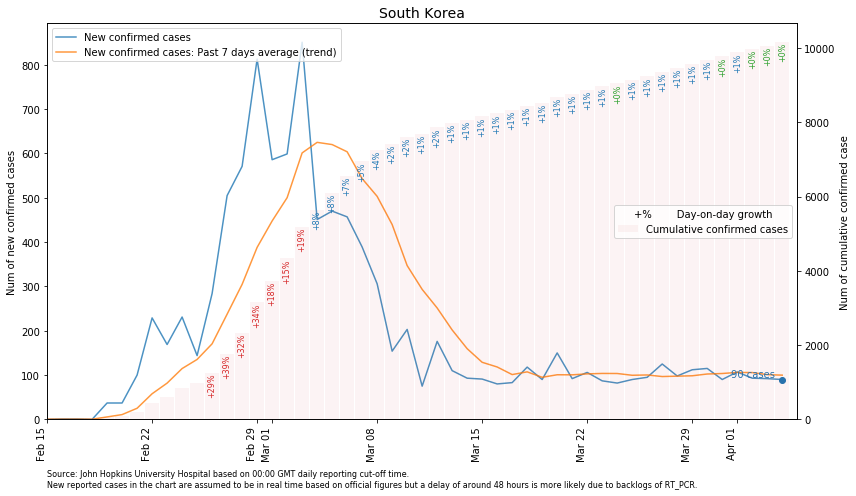

In [56]:
# Assign values
country   = 'South Korea'
xmin      = pd.to_datetime('20200215', format='%Y%m%d')
txtmin    = pd.to_datetime('20200225', format='%Y%m%d')
lockstart = data0.date.min()
locklabel = 'No lockdown'

# Define data points
fig, ax = plt.subplots(figsize=(12,7))
data0 = df1.loc[df1.country==country].reset_index()
data0 = data0.sort_values('date').reset_index(drop=True)[['date','confirmed','new_confirmed','growth']]
data1 = data0.new_confirmed.rolling(window=7).mean()
lockend = data0.date.max()

# Daily cases
ax.plot(data0.date, data0.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
ax.plot(data0.date, data1, label='New confirmed cases: Past 7 days average (trend)', alpha=0.8, color='C1')

data0lock = data0[data0.date==lockstart].new_confirmed.values[0]
data1lock = data1[data0[data0.date==lockstart].index[0]]
data0now = data0.new_confirmed.iloc[-1]
data1now  = data1.iloc[-1]
ax.scatter(lockend, data0now, marker='o', color='C0')
ax.text(lockend-oneday/2, data0now, f'{int(data0now)} cases', va='bottom', ha='right', color='C0')

# Cumulative cases
ax2 = ax.twinx()
ax2.bar(data0.date, data0.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
for i in data0[data0.date>txtmin].index:
    if data0.iloc[i].growth >= 1.1: color='C3'
    elif data0.iloc[i].growth >= 1.01: color='C0'
    else: color='C2'
    ax2.text(data0.iloc[i].date, data0.iloc[i].confirmed, f'+{int((data0.iloc[i].growth-1)*100)}%',
             rotation=90, ha='center', va='top', color=color, fontsize=8)

# Axis labels 
ax.set_xlim(xmin, data0.date.max()+oneday)
ax.set_ylim(0, data0.new_confirmed.max()*1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Num of new confirmed cases')
ax2.set_ylabel('Num of cumulative confirmed case')
plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='center right', title='+%        Day-on-day growth')
ax.set_title(country, fontsize=14)
plt.tight_layout()
plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
plt.show()